In [58]:
# load the libraries 

import sys
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import os
import h5py
import PIL
import cv2
import tensorflow as tf
import tensorflow.keras as keras

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams["figure.figsize"] = (14,8)

Загрузка данных

In [59]:
input_folder = '/kaggle/input/russian-handwritten-letters/all_letters_image/all_letters_image/'
all_letters_filename = os.listdir(input_folder)
len(all_letters_filename)

14190

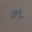

In [60]:
i = Image.open("/kaggle/input/russian-handwritten-letters/all_letters_image/all_letters_image/20_102.png")
i

Это одно из наших изображений. Каждое изображение имеет размер 32 на 32 пикселя. Затем мы конвертируем каждое изображение в трехмерный массив numpy.

In [61]:
def img_to_array(img_name, input_folder):
    img = image.load_img(input_folder + img_name, target_size=(32,32))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)
def data_to_tensor(img_names, input_folder):
    list_of_tensors = [img_to_array(img_name, input_folder) for img_name in img_names]
    return np.vstack(list_of_tensors)

In [62]:
data = pd.read_csv("../input/russian-handwritten-letters/all_letters_info.csv")
image_names = data['file']
letters = data[ 'letter']
backgrounds = data['background'].values
targets = data['label'].values
tensors = data_to_tensor(image_names, input_folder)


In [63]:
print ('Tensor shape:', tensors.shape)

Tensor shape: (14190, 32, 32, 3)


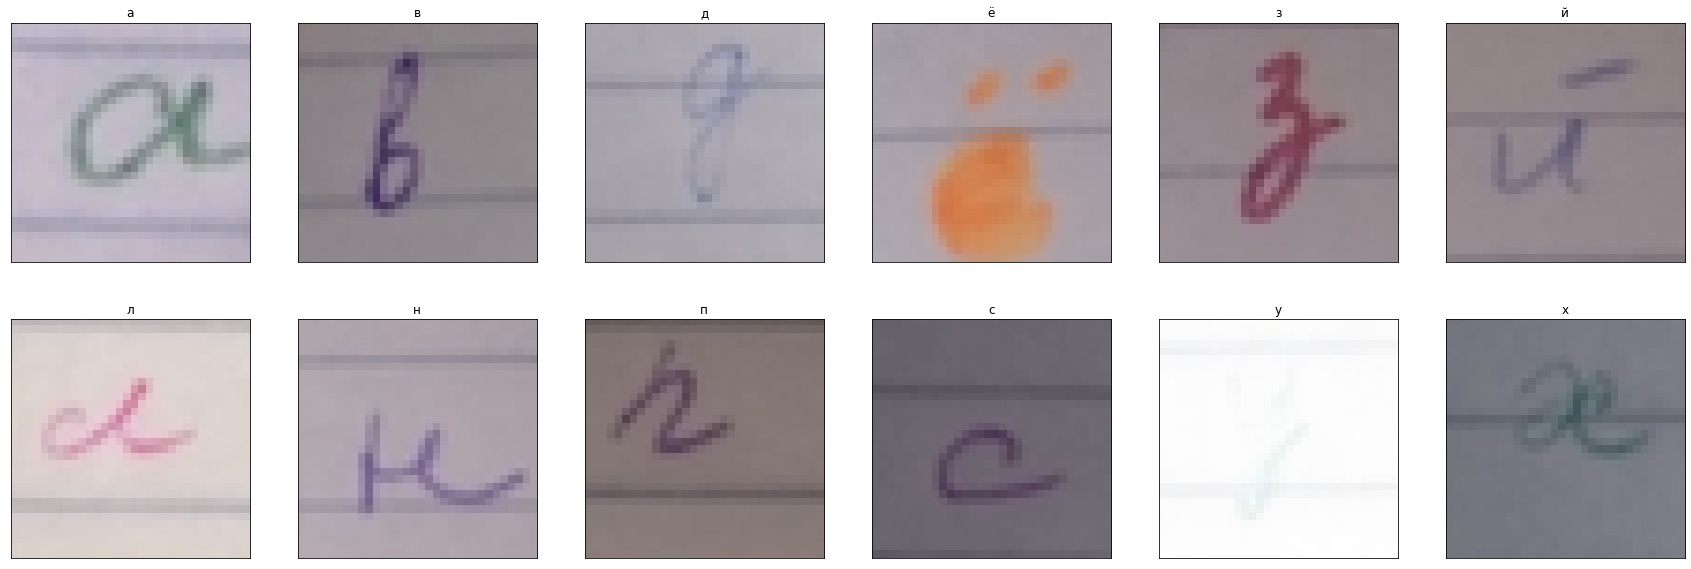

In [64]:
def display_images(img_path, ax):
    img = cv2.imread(input_folder + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(30, 10))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i*100])
    display_images(image_names[i*100], ax)

нормализация данных

In [65]:
X = tensors.astype("float32")/255

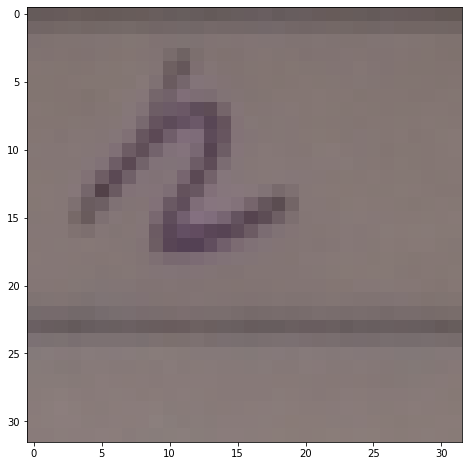

In [66]:
arr = X[800]
arr_ = np.squeeze(arr)
plt.imshow(arr_)
plt.show()

In [67]:
targets[0]

1

In [68]:
y = targets
img_rows, img_cols = 32, 32
num_classes = 33 
y = keras.utils.to_categorical(y-1, num_classes)

In [69]:
print(X.shape)
print(y.shape)

(14190, 32, 32, 3)
(14190, 33)


Разделение данных

In [70]:
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_whole, y_train_whole, test_size=0.1, random_state=1)

In [71]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample/image mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen

In [72]:
# Define the model architecture

deep_RU_model = Sequential()

deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (img_rows,img_cols,3)))
deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2)))
deep_RU_model.add(Dropout(0.25))


deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
deep_RU_model.add(Dropout(0.25))

deep_RU_model.add(Flatten())
deep_RU_model.add(Dense(256, activation = "relu"))
deep_RU_model.add(Dropout(0.5))
deep_RU_model.add(Dense(33, activation = "softmax"))

In [73]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [74]:
# Compile the model: 

deep_RU_model.compile(loss="categorical_crossentropy", optimizer = optimizer,metrics=["accuracy"])

In [75]:
history = deep_RU_model.fit(datagen.flow(X_train,y_train, batch_size=90), validation_data = (X_val, y_val),epochs=139)

Epoch 1/139
128/128 [==============================] - 56s 429ms/step - loss: 3.5053 - accuracy: 0.0303 - val_loss: 3.4878 - val_accuracy: 0.0305
Epoch 2/139
128/128 [==============================] - 55s 426ms/step - loss: 3.4863 - accuracy: 0.0360 - val_loss: 3.4491 - val_accuracy: 0.0516
Epoch 3/139
128/128 [==============================] - 55s 429ms/step - loss: 3.4682 - accuracy: 0.0408 - val_loss: 3.4143 - val_accuracy: 0.0548
Epoch 4/139
128/128 [==============================] - 55s 430ms/step - loss: 3.4353 - accuracy: 0.0517 - val_loss: 3.4361 - val_accuracy: 0.0454
Epoch 5/139
128/128 [==============================] - 55s 426ms/step - loss: 3.3933 - accuracy: 0.0554 - val_loss: 3.3291 - val_accuracy: 0.0712
Epoch 6/139
128/128 [==============================] - 55s 430ms/step - loss: 3.3753 - accuracy: 0.0628 - val_loss: 3.3255 - val_accuracy: 0.0720
Epoch 7/139
128/128 [==============================] - 55s 430ms/step - loss: 3.3592 - accuracy: 0.0576 - val_loss: 3.2527 -

оценка модели

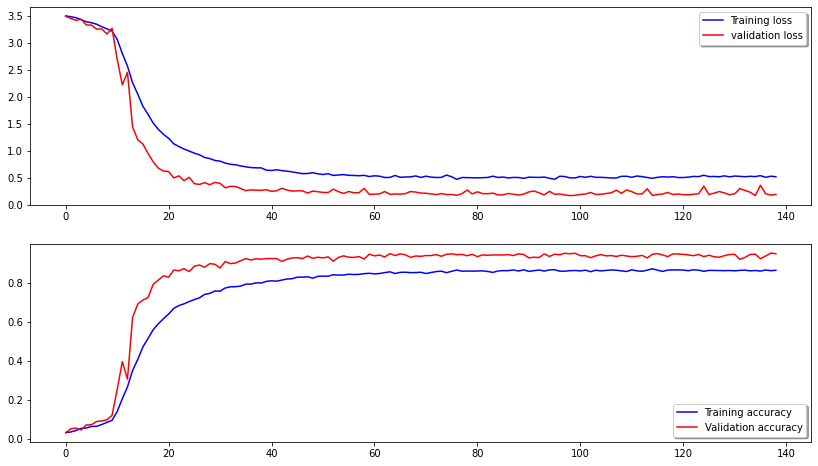

In [76]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Confusion matrix

<AxesSubplot:>

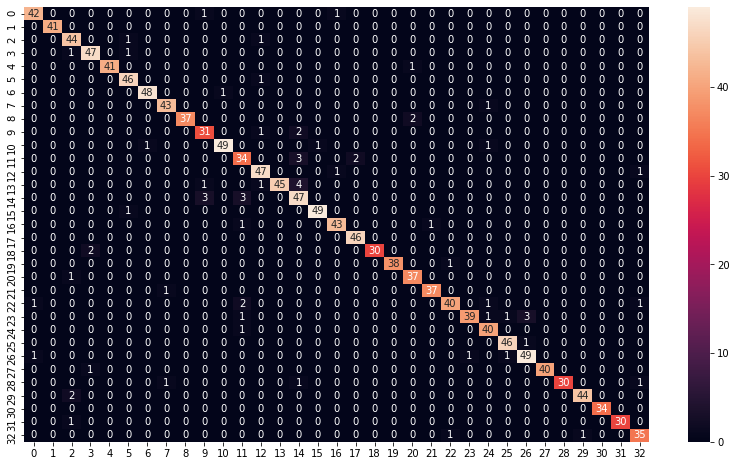

In [79]:
y_pred = deep_RU_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_test, y_pred) 
sns.heatmap(confusion_mtx, annot=True, fmt='d')